# Assignment 2

## Importing relevant data
Based on previous work the edgelist including attributes of textlen and universe is imported into a digraph, and the pandas dataframe containing relevant data is likewise loaded.

In [2]:
import pandas as pd
from collections import Counter
import json
import os.path
import networkx as nx
from networkx.readwrite import json_graph
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import powerlaw
import community
import matplotlib.cm as cm
from networkx.algorithms.community.quality import modularity
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import random

In [3]:
# Get the superhero dataframe
df_superhero = pd.read_csv('df_superhero.csv')
df_superhero.head()

,Unnamed: 0.1,Unnamed: 0,CharacterName,WikiLink,file,universe,WikiOutLinks,TextLen
0,0,0,Abin Sur,['Abin Sur'],Abin_Sur.json,dc,"['Special:ApiFeatureUsage', 'DC Comics', 'John...",5351
1,1,1,Abra Kadabra (character),['Abra Kadabra (character)'],Abra_Kadabra_%28character%29.json,dc,"['Special:ApiFeatureUsage', 'Oscar Jimenez (co...",2740
2,2,2,Abby Holland,['Abby Holland'],Abby_Holland.json,dc,"['Special:ApiFeatureUsage', 'File:SwampThing22...",4446
3,3,3,Ace the Bat-Hound,['Ace the Bat-Hound'],Ace_the_Bat-Hound.json,dc,"['Special:ApiFeatureUsage', 'Detective Comics'...",3294
4,6,6,Adam Strange,['Adam Strange'],Adam_Strange.json,dc,"['Special:ApiFeatureUsage', 'Alex Ross', 'DC C...",7533


In [4]:
# Create a directed graph from the superhero network
G_superhero = nx.DiGraph()

with open(f"supernetwork.json", "r") as infile:
    json_data = json.load(infile)
    G_superhero = json_graph.adjacency_graph(json_data)

## Basic stats

#### Task:
- Write a short paragraph describing the network. The paragraph should contain the following information
- The number of nodes and links.
- The average, median, mode, minimum and maximum value of the network's in-degree.s And of the out-degrees.

In [5]:
in_super = sorted([d for n, d in G_superhero.in_degree()], reverse=True)
out_super = sorted([d for n, d in G_superhero.out_degree()], reverse=True)

print(f'The network has a total number of {len(G_superhero.nodes())} nodes and {G_superhero.number_of_edges()} edges.'+
      f' The average degree is {sum(in_super)/len(in_super)}.'+
        f' The median in-degree is {in_super[len(in_super)//2]} and the median out-degree is {out_super[len(out_super)//2]}.'+
        f' The maximum in-degree is {in_super[0]}, the maximum out-degree is {out_super[0]}.'+
        f' And finally the mode in-degree is {Counter(in_super).most_common(1)[0][0]} and the mode out-degree is {Counter(out_super).most_common(1)[0][0]}.')

The network has a total number of 1585 nodes and 21601 edges. The average degree is 13.62839116719243. The median in-degree is 6 and the median out-degree is 10. The maximum in-degree is 433, the maximum out-degree is 90. And finally the mode in-degree is 1 and the mode out-degree is 6.


The observation that the max in-degree is 433, but the mode in-degree is just 1, tells us that especially on the in-ward connection the network is very uneven with properties that resemble behavior of a highly scale-free network. Outdegrees are distributed more evenly, and in combination with the in-degree, it means that generally nodes have a number of outlinks each, but many of these point to a few central hubs.

### Task: We also want the degree distributions and a plot of the network

- Create in- and out-going degree distributions as described in Lecture 5.
- Estimate the slope of the incoming degree distribtion as described in Lecture 5.
- Plot the network using the Force Atlas algorithm as described in Lecture 5.

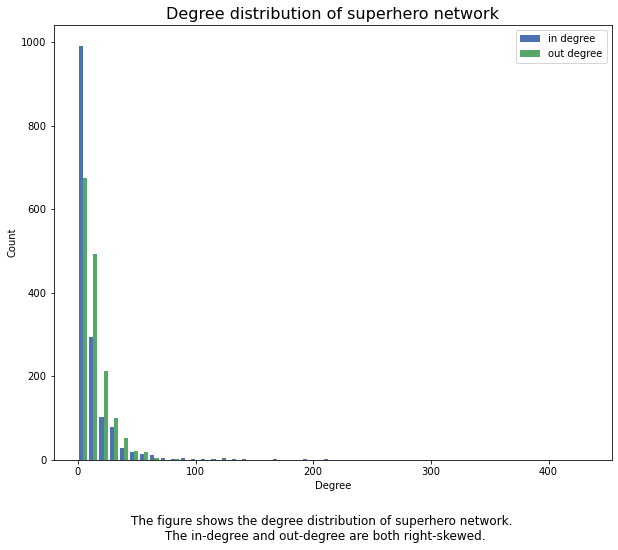

In [51]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.style.use('seaborn-deep')
ax.hist([in_super, out_super], bins=50, label=['in degree', 'out degree'])
ax.legend(loc='upper right')
#plt add caption
ax.set_xlabel('Degree')
ax.set_ylabel('Count')
ax.set_title('Degree distribution of superhero network', fontsize=16)
#add description to figure and avoid overlapping xlabel
fig.text(0.5, -0.01, 'The figure shows the degree distribution of superhero network. \n The in-degree and out-degree are both right-skewed.', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

In total the number of in and out degrees must be equal to one another, but there is a higher proportion of nodes with a low in degree, than there are nodes with a low out-degree. It means that it is more common for nodes to have just a few in-connections, and more common to have more out-connections.

This is possible due to a few nodes that have a lot of in-wards links, central hubs like Spiderman, Batman etc. where a lot of other characters link to, but these hubs link less outwards.  

In [32]:
slope_super = powerlaw.Fit(in_super).alpha
print(f'The slope of the in-degree distribution is {slope_super}')

The slope of the in-degree distribution is 2.519458485615602


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/caro/opt/anaconda3/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


In [33]:
#Theoretical size of largest hub, assuming k_min = 1
k_max_predicted= np.power(len(G_superhero.nodes()),(1/(slope_super-1)))
print(f'expected largest hub {k_max_predicted}')

#Highest k in the network (in)
print(f'Largest hub in the superhero network {max(in_super)}')


expected largest hub 127.65349397765296
Largest hub in the superhero network 433


A degree exponent of 2.52 imply that the network is in the Scale-Free regime. This predicts a number of features, such as:
- Large number of small degree nodes that connected primarily via a few centrail nodes (hubs) that have an extremely high degree relative to the most common degree size (confirmed via plots)
- hubs are expected in scale-free network, and grow polynomially with network size. In this case the largest node would be expected to have 128 in links, whereas in fact it has 433 making this behavior even closer to 
- the network structure enables the 'ultra small world' property, which imply that the distance from any two nodes in the network is significantly smaller than in a random network


#### Network plot using Force Atlas

In [34]:
#Extracting the giant component of the graph
superhero_subgraphs = [G_superhero.subgraph(
    c).copy() for c in nx.weakly_connected_components(G_superhero)]
GC_superhero = max(superhero_subgraphs, key=len)

#Making the graph unidirectional
GC_super_un = GC_superhero.to_undirected()

#Coloring nodes based on the universe of the character
universe_color = []
for char in GC_super_un.nodes():
    if GC_super_un.nodes[char]['universe'] == 'dc':
        universe_color.append('#034078')
    elif GC_super_un.nodes[char]['universe'] == 'marvel':
        universe_color.append('#ff206e')

#Scaling the size of the nodes relative to their size
degree_list = []
for char in GC_super_un.nodes():
    degree_list.append(GC_super_un.degree(char))

# normalize node size to highest degree with max size = 30
max_degree = max(degree_list)
node_size_list = [x/max_degree*200 for x in degree_list]


100%|██████████| 500/500 [00:07<00:00, 67.26it/s]


BarnesHut Approximation  took  2.62  seconds
Repulsion forces  took  4.37  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.09  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds


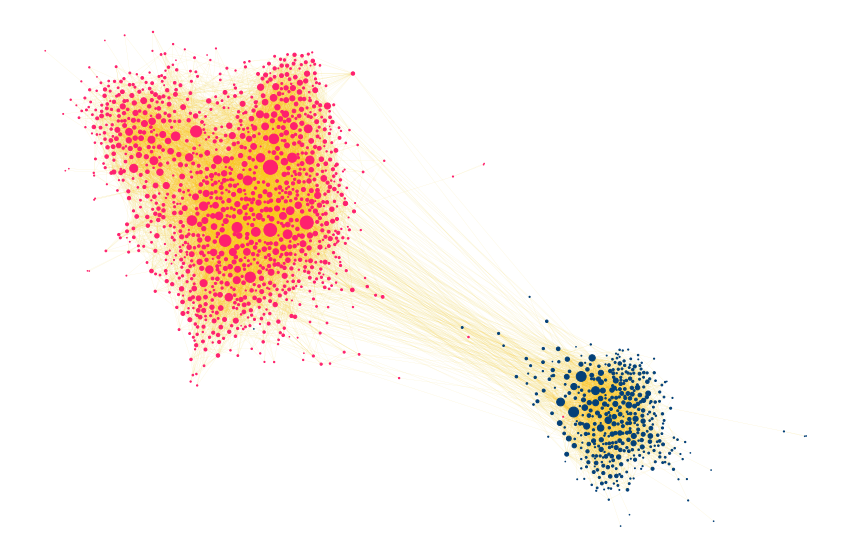

In [37]:
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1,

    # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1,
                        strongGravityMode=True,
                        gravity=5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(
    GC_super_un, pos=None, iterations=500)

fig, ax = plt.subplots(figsize=(15, 10))
nx.draw(GC_super_un, pos=positions, with_labels=False, node_size=node_size_list,
        width=0.05, node_color=universe_color, edge_color='#f9c80e')


The split within the marvel universe (red) indicate that there are two 'sub-groupings'. A theory could for example be that there exist a lot of links between avenger characters, originally Iron Man, Captain America, Thor, Hulk, Black Widow and Hawkeye (both movie and comics), and that in a somewhat seperate community the most connected character, Spider-man, has some groupings of his own. Untill 2015 the movie rights for Spiderman was solely Sony's and therefor Spiderman did not appear in any avenger/marvel movies, potentieally limiting the amount of links to other marvel movie characters historically speaking. It could also be that it is another sub-community of super heroes..

## Communities

In [39]:
# Load super network
with open(f"supernetwork.json", "r") as infile:
    json_data = json.load(infile)
    G_superhero = json_graph.adjacency_graph(json_data)

In [40]:
# Get the largest component
superhero_subgraphs = [G_superhero.subgraph(
    c).copy() for c in nx.weakly_connected_components(G_superhero)]
GC_superhero = max(superhero_subgraphs, key=len)

In [41]:
# Create the undirected graph
GC_super_un = GC_superhero.to_undirected()

## Communities

### Task:  Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.

In [42]:
# Build a strictly marvel based network..
marvel_nodes = (node for node, data in GC_super_un.nodes(data=True) if data.get("universe") == "marvel")
G_marvel_un = GC_super_un.subgraph(marvel_nodes)

In [43]:
# Identify communities in the Marvel universe using the Louvian algorithm
partition_marvel = community.best_partition(G_marvel_un)

### Task: Visualize the communities by coloring the graph's nodes according to community affiliation - also as described in Week 7.

100%|██████████| 500/500 [00:06<00:00, 81.73it/s] 


BarnesHut Approximation  took  1.78  seconds
Repulsion forces  took  3.94  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.07  seconds
AdjustSpeedAndApplyForces step  took  0.14  seconds


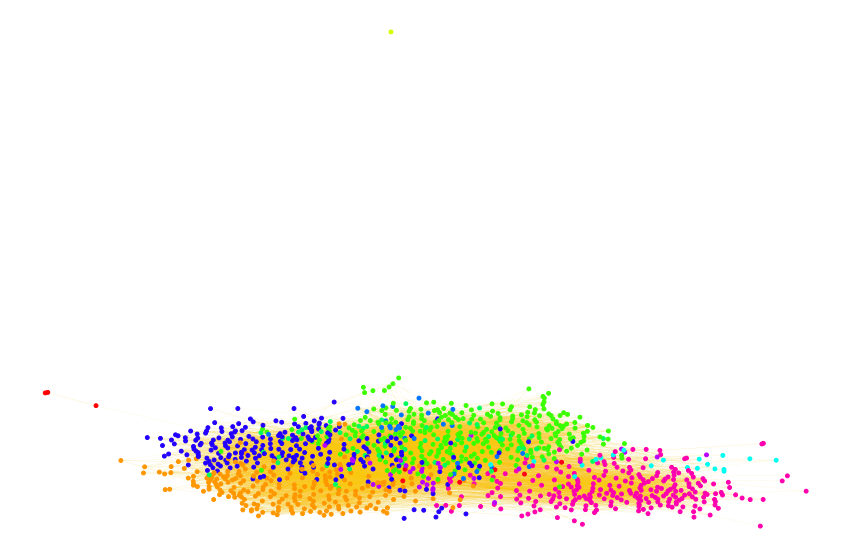

In [47]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_marvel_un, pos=None, iterations=500)

fig, ax = plt.subplots(figsize=(15, 10))
# color the nodes according to their partition
cmap = cm.get_cmap('hsv', max(partition_marvel.values()) + 1)
nx.draw(G_marvel_un, pos=positions, with_labels=False, node_size=15, width=0.05, 
        cmap=cmap, node_color=list(partition_marvel.values()), edge_color='#f9c80e')
plt.show()

### Write a paragraph about your work to identify the communities.

* Algorithm you used to find communities.

For the community detection we are using the Louvain Algorithm. The algorithm, like many other community algorithms, is based on optimizing the modularity of the network. Modularity is a relative score from -0.5 to 1 that indicate how densely connected a number of nodes are linked together, relative to the expected number of links of a similar degree distributed random graph. A modularity higher than 0, indicate that a given group of nodes are more connected that one would expect if it was random, and therefor has the potential to represent a community. A combined modularity score of the graph can be found by adding and averaging over all detected communities, and the assumption is, that maximizing M over the entire graph provide the best parition of communities. 

The Louvains algorithm optimize for the highest modularity score in two repeated steps, after initiallity splittng the graph and assuming that each node belongs to its own community:
- 1: For each node, evaluate the gain in modularity if the node is placed in a communiy with one of its neigbhors, join the node where the modularity gain is maximized, and if non is gained, stay in the original community. Run untill no further improvements can be achieved.
- 2: Construct a new network where each node are the communities from step1, and the weight of the links between two nodes (that consist a number of nodes) are the sum of the links in the corresponding community. 

Step 1-2 is repeated untill no gain in maximum modularity is attained.

Like other algorithms based on modularity maximuzation, this approach "suffer" from the simplification that no node can be part of two communities, which in reality often is the case. An alternative approach would be to generate communities based on link clustering that allow nodes to be part of several communities.

* The value of modularity for the network.

The Marvel network has a modularity of approx. 0.38 indicating the pressence of communities. 

In [48]:
# Get lists of partitions to use for calculating modularity
partition_list_marvel = {}
for pair in partition_marvel.items():
    if pair[1] not in partition_list_marvel.keys():
        partition_list_marvel[pair[1]] = []

    partition_list_marvel[pair[1]].append(pair[0])

In [49]:
# Calculate the modularity
modularity(G_marvel_un, partition_list_marvel.values())

0.373656303837367

* The number of communities and their sizes (in terms of number of nodes).

A total of 11 communities were detected in the Marvel universe
Community 7 has 243 nodes
Community 1 has 227 nodes
Community 3 has 323 nodes
Community 9 has 251 nodes
Community 4 has 54 nodes
Community 5 has 20 nodes
Community 8 has 34 nodes
Community 6 has 28 nodes
Community 10 has 6 nodes
Community 0 has 3 nodes
Community 2 has 1 nodes


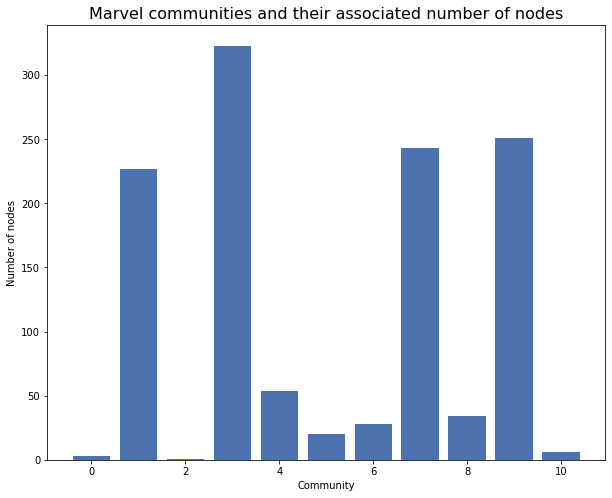

In [54]:
#number of communities detected
print(f'A total of {len(partition_list_marvel.keys())} communities were detected in the Marvel universe')
for comm in partition_list_marvel.keys():
    #sorted according to number of nodes
    print(f"Community {comm} has {len(partition_list_marvel[comm])} nodes")


import matplotlib.pyplot as plt
#plot bar chart of each community and the number of nodes in it sorted according to number of nodes in each community:
sorted_communities = sorted(partition_list_marvel.items(), key=lambda x: len(x[1]), reverse=True)
fig, ax = plt.subplots(figsize=(10, 8))
plt.bar([x[0] for x in sorted_communities], [len(x[1]) for x in sorted_communities])
ax.set_xlabel('Community')
ax.set_ylabel('Number of nodes')
ax.set_title('Marvel communities and their associated number of nodes', fontsize=16)
plt.show()

The number of communities detected vary as the algorithm is run , but typically result in a total of 9-11 commmunities. A few large communities, typically with +200 nodes, make up a large proportion of the network. As seen from the commulitative plot below, roughly 90% of all nodes are included in the 5 largest communities. The remaining commmunities held a smaller number of nodes, typically 10-50, and a single community of just 1 node.

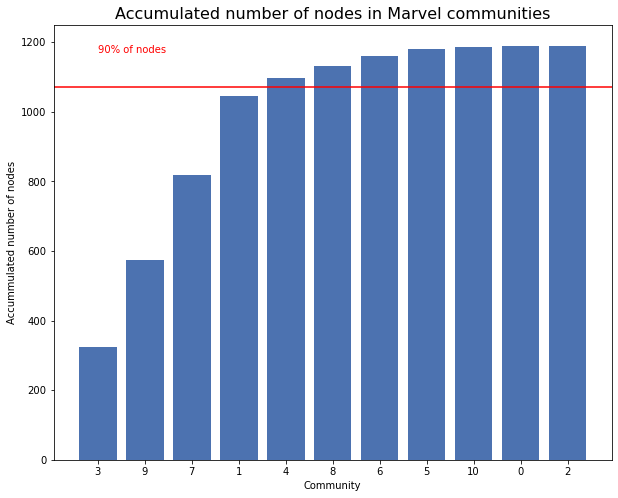

In [55]:
#plot a bar chart with the accumulated number of nodes in each community sorted according to number of nodes in each community:
fig, ax = plt.subplots(figsize=(10, 8))
plt.bar(([str(x[0]) for x in sorted_communities]), [sum([len(x[1]) for x in sorted_communities[:i+1]]) for i in range(len(sorted_communities))])
ax.set_xlabel('Community')
ax.set_ylabel('Accummulated number of nodes')
ax.set_title('Accumulated number of nodes in Marvel communities', fontsize=16)
#add threshold at 90% of the total number of nodes
plt.axhline(y=0.9*len(G_marvel_un.nodes()), color='r', linestyle='-')
#add text at the threshold
plt.text(0, 0.9*len(G_marvel_un.nodes())+100, '90% of nodes', color='red')
plt.show()

### Task: For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.

In [56]:
# Get the 10 largest communities from the sorted communities list
sorted_communities = sorted_communities[:10]

We have chosen to work with the Marvel universe only, so we will create a pickle file only consisting of Marvel characters

In [57]:
# Get the pickle file of all heroes
df_superhero = pd.read_pickle('df_superhero_pkl.pkl')

# Create pickle file with only Marvel characters
df_marvel = df_superhero[df_superhero['universe'] == 'marvel']

#### Collect the text of all characters in a community to a single document
* stored as a dict[community_number] = "combined wiki text"

In [58]:
community_text = {}

#Iterate over each community
for comm_list in sorted_communities:
    #create a item in the dict with key = community number, and value = empty string
    community_text[comm_list[0]] = ''
    #iterate through each node in the community
    for node in comm_list[1]:
        #to identify the associated filename and append wikitext, iterate through the dataframe
        for wikilink, file in zip(df_marvel.WikiLink, df_marvel.file):
        #match the node name with wikilink, and add the text of the node using the file-name association and json loads
            if node == wikilink[0]:
                    with open(f"../wikidata/{file}", "r") as infile:
                        jsonwiki = json.load(infile)
                        #converts the json to a string
                        text_content = str(jsonwiki['query']['pages'])
                        for page in jsonwiki['query']['pages']:
                            #page id -1 occur when an empty page is returned
                            if page != '-1': 
                                #extracts the text from the json
                                text_content = jsonwiki['query']['pages'][page]['revisions'][0]['*']
                                #appends the text to the community text
                                community_text[comm_list[0]] += str(text_content)

#### Tokenize text

In [59]:
import nltk
from nltk.tokenize import word_tokenize

# Tokenize the community texts
for comm in community_text.keys():
    community_text[comm] = word_tokenize(community_text[comm])

#### Lemmatize the text

In [60]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN

community_text_lem = {}
for comm in community_text.keys():
    lemmatized_words = []
    tagged_comm = nltk.pos_tag(community_text[comm])
    for word, tag in tagged_comm:
        wntag = get_wordnet_pos(tag)
        lemmatized_words.append(lemmatizer.lemmatize(word, pos=wntag))
    community_text_lem[comm] = lemmatized_words


#### Create freq distribution (raw count)

In [61]:
#filter off stopwords
stopwords = nltk.corpus.stopwords.words('english')
#As it turns out, the word "ref", and 'category' are amongst the most used across all our wikipedia 
#because these are part of the wikitext structure, to filter theese we add them to the exception list
stopwords.append('ref')
stopwords.append('category')

freqDist = {}

# Calculate the frequency distribution of the words in each community
#only process words, and consider all words as lower-case
for comm in community_text_lem.keys():
    freqDist[comm] = nltk.FreqDist(word.lower() for word in community_text_lem[comm] if word.isalpha() and word.lower() not in stopwords)

In [62]:
# Get the top 5 words in each community
for comm in sorted(freqDist.keys()):
    print(f'Community {comm} top 5 words: {freqDist[comm].most_common(5)}')

Community 0 top 5 words: [('comics', 48), ('twelve', 40), ('comic', 29), ('character', 26), ('marvel', 25)]
Community 1 top 5 words: [('marvel', 9315), ('comic', 5023), ('comics', 4427), ('character', 4216), ('cite', 3379)]
Community 3 top 5 words: [('marvel', 14013), ('comic', 7214), ('comics', 6466), ('character', 4923), ('cite', 4883)]
Community 4 top 5 words: [('marvel', 1913), ('comic', 931), ('comics', 917), ('character', 817), ('cite', 751)]
Community 5 top 5 words: [('flight', 500), ('marvel', 349), ('comic', 301), ('alpha', 272), ('hero', 265)]
Community 6 top 5 words: [('marvel', 1479), ('comic', 813), ('runaways', 647), ('nico', 581), ('comics', 548)]
Community 7 top 5 words: [('marvel', 8872), ('comic', 5077), ('comics', 4271), ('man', 4054), ('avengers', 3607)]
Community 8 top 5 words: [('marvel', 714), ('comic', 578), ('comics', 460), ('new', 460), ('warriors', 425)]
Community 9 top 5 words: [('marvel', 7116), ('comic', 6270), ('comics', 4978), ('mutant', 3451), ('charact

As we can see from the frequency distribution, the most common words in each community are words such as 'marvel' and 'comics' which is no surprise. However, from this alone we do not get a lot of information about what characterizes each community.

### Calculating IDF

The inverse document frequency (IDF) deterimnes how important a term (word) is, relative to a corpus of documents. Since our purpose is to figure out what charactarizes the communities
within the marvel universe. We therefore decide to let "the corpus of N documents" refer to corpus = all communities, and a document to a community. 

This way we expect our TD-IDF to be able to determine what words are most distinctive for a given community, in the context of a marvel universe (hence omitting words like "marvel", "character", "comic", etc.))

In [63]:
idf = {}

for comm in freqDist.keys():
    #for each community (number)
    for word in freqDist[comm].keys():
        #if the word has not been IDF scored yet
        if word not in idf.keys():
            for freq_dict in freqDist.values():
                if word in freq_dict.keys():
                    #if the word is in the frequency dict of a given community, 1 to the IDF score
                    if word not in idf.keys():
                        idf[word] = 1
                    else:
                        idf[word] += 1
            #Divide the total number of communities ("documents ") with the number of communities in which the word appeared
            idf[word] = len(freqDist.keys())/ idf[word]
            idf[word] = np.log2(idf[word])

print('We would expect that the word marvel carry no weight as it is present in every community: the IDF score is: ', idf['marvel'])
print('We would expect that the word Kung carry some weight as it seems like a rather community specific word: the IDF score is:', idf['kung'])

We would expect that the word marvel carry no weight as it is present in every community: the IDF score is:  0.0
We would expect that the word Kung carry some weight as it seems like a rather community specific word: the IDF score is: 0.5145731728297582


### Calculating TF - IDF

In [64]:
#Calculate the Term Frequency - TF - simply by dividing the raw frequency count with the total number of words in a given text
#This is done to make the TF-IDF score independent of the size of the community
for comm in freqDist.keys():
    for word in freqDist[comm].keys():
        freqDist[comm][word] = freqDist[comm][word]/len(community_text_lem[comm])


In [65]:
tf_idf = {}

for comm in freqDist.keys():
    tf_idf[comm] = {}
    # For each word in the community, multiply the TF and IDF score
    for word in freqDist[comm].keys():
        tf_idf[comm][word] = freqDist[comm][word] * idf[word]


In [66]:
# List the top 10 words in each community according to TF-IDF
for comm in sorted(tf_idf.keys()):
    print(f'Community {comm} top 10 words according to TF-IDF: {sorted(tf_idf[comm].items(), key=lambda x: x[1], reverse=True)[:10]}')

Community 0 top 10 words according to TF-IDF: [('rockman', 0.012394633958473464), ('twelve', 0.00523206073034833), ('komics', 0.0033776594762454115), ('clete', 0.0033776594762454115), ('abyssmia', 0.0025332446071840587), ('wolverton', 0.00236088265875685), ('rose', 0.0018312212556219154), ('engen', 0.0016888297381227057), ('abyssmian', 0.0016888297381227057), ('basil', 0.0013441058412682891)]
Community 1 top 10 words according to TF-IDF: [('gwen', 0.000953647338709733), ('amazing', 0.0006603249270545761), ('harry', 0.0006155966690639386), ('jane', 0.0005913458911917229), ('goblin', 0.0005718034472397066), ('octopus', 0.0005475938355615368), ('hobgoblin', 0.0005063811599698465), ('octavius', 0.0004997576476336406), ('macendale', 0.0004680805037578011), ('mj', 0.0004545174955925598)]
Community 3 top 10 words according to TF-IDF: [('thor', 0.00048411493883179866), ('web', 0.00035431910496655934), ('surfer', 0.0003130803398372115), ('hulk', 0.0003125838678476587), ('kirby', 0.0003025163629

### Visualize TF-IDF using wordclouds 

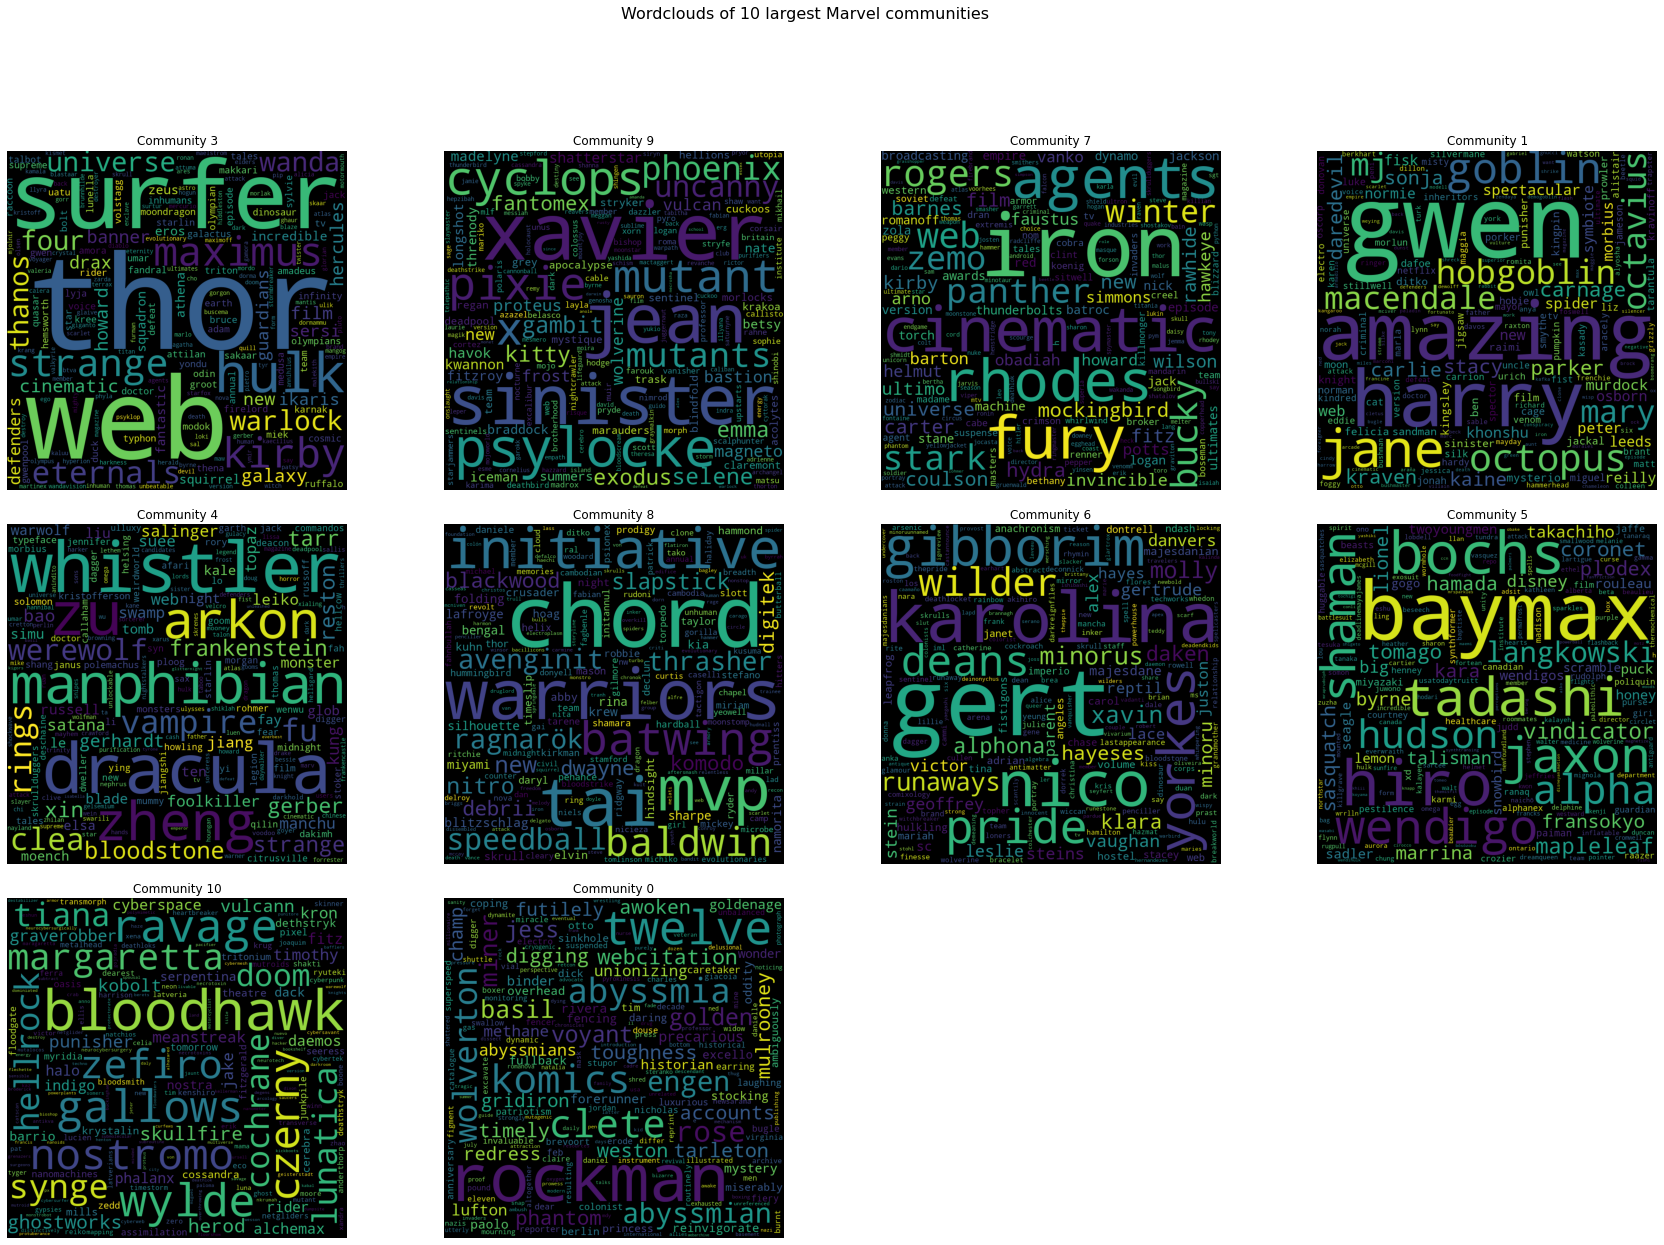

In [81]:
# Create a word cloud for each community
from wordcloud import WordCloud, STOPWORDS

fig, axs = plt.subplots(figsize=(30, 20))
plt.subplots_adjust(hspace=0.1)
fig.suptitle("Wordclouds of 10 largest Marvel communities", fontsize=16)

for n, comm in enumerate(tf_idf.keys()):
    wordcloud = WordCloud(
                width = 800, 
                height = 800,
                background_color ='black',
                stopwords = STOPWORDS,
                collocations=False,
                ).generate_from_frequencies(tf_idf[comm])
    
    # Create a subplot of the wordcloud
    ax = plt.subplot(3, 4, n + 1)
    
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set_title(f'Community {comm}')

plt.show()

The TF-IDF enables us to understand what make up the different communities much better. From looking at the highlighted words in the wordclouds, we can easily identify the community of the marvel universe. One community can be identified as the Spiderman community, another as X-men and another as avengers and so on.

# Sentiment analysis
### Task: First calculate the sentiment for all character pages. Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment.

We first extract the raw text and then tokenize it, in order to get clean data for calculating sentiment:

In [25]:
def get_raw_text(df):
    raw_text = []
    trouble_pages = []
    for i in range(len(df)):
        with open("../wikidata/"+df_superhero['file'][i]) as json_file:
            data = json.load(json_file)
            temp = list(data["query"]["pages"].keys())[0] #getting key that varies per inputdata.keys()
            try:
                text = data["query"]["pages"][temp]["revisions"][0]["*"]
                raw_text.append(text)
            except KeyError: #In case the wiki does not exist, we
                #print(f"The character {df_superhero['CharacterName'][i]} with index {i} has no text")
                raw_text.append(None)
                trouble_pages.append(i)
    return raw_text, trouble_pages

A few corrupted character pages escaped in the cleaning process of our dataset generation. These are marked and kept track of:

In [26]:
raw_text, trouble_pages = get_raw_text(df_superhero)
print(f"There are {len(trouble_pages)} pages without text")
print(f"There are {len(raw_text)-len(trouble_pages)} pages with text")


There are 21 pages without text
There are 1598 pages with text


We now tokenize the text. In doing so we remove stop words. This is not necessary, since many of these words have an associated sentiment score. However, we still remove them because we deem that they add too much noise, since their sentiment ranking is weighted equally with all other words.

In [31]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

def get_tokens(raw_str):
    tokens = tokenizer.tokenize(raw_str)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if not token in stop_words]
    return tokens

tokens = []

for text in raw_text:
    if text is not None: #taking care of character pages without any words
        tokens.append(get_tokens(text))
    else:
        tokens.append(None)

Next we load in the LabMT wordlist which will be used as a sentiment dictionary


In [32]:
LabMT = pd.read_csv("../provided_csvs/pone.0026752.s001.txt", delimiter= '\t', skiprows=2)
LabMT.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


We now create a list of the mean sentiment for each character page (this takes a while to run):

In [ ]:
mean_list = []

for i in range(len(tokens)):
    sent_list = []
    for token in tokens[i]:
        if token in LabMT["word"].values:
            sent_list.append(LabMT["happiness_average"][LabMT["word"] == token].values[0])
    mean_list.append(np.mean(sent_list))

Saving scores to dataframe for easier loading:

In [34]:
#df_superhero["Sentiment"] = mean_list #saving
#df_superhero.to_csv("Superhero_sentiment.csv")
df_superhero = pd.read_csv('Superhero_sentiment.csv') #loading
df_superhero = df_superhero.replace(np.nan,None) #Making sure empty character pages have type None sentiment
mean_list = df_superhero["Sentiment"]

### Task: create a nice histogram displaying the distribution of sentiment values for all pages. Indicate the mean, etc on that histogram.

In [35]:
def get_histogram_data(mean_list):
    means = [number for number in mean_list if number != None]
    overal_mean = np.mean(means)
    ninetieth = np.percentile(means, 90)
    tenth = np.percentile(means,10)
    histogram=np.histogram(means,bins=25)

    return means, overal_mean, ninetieth, tenth, histogram

means, overal_mean, ninetieth, tenth, histogram = get_histogram_data(mean_list)


Now plotting a histogram of the distribution of the mean sentiment scores for each character page


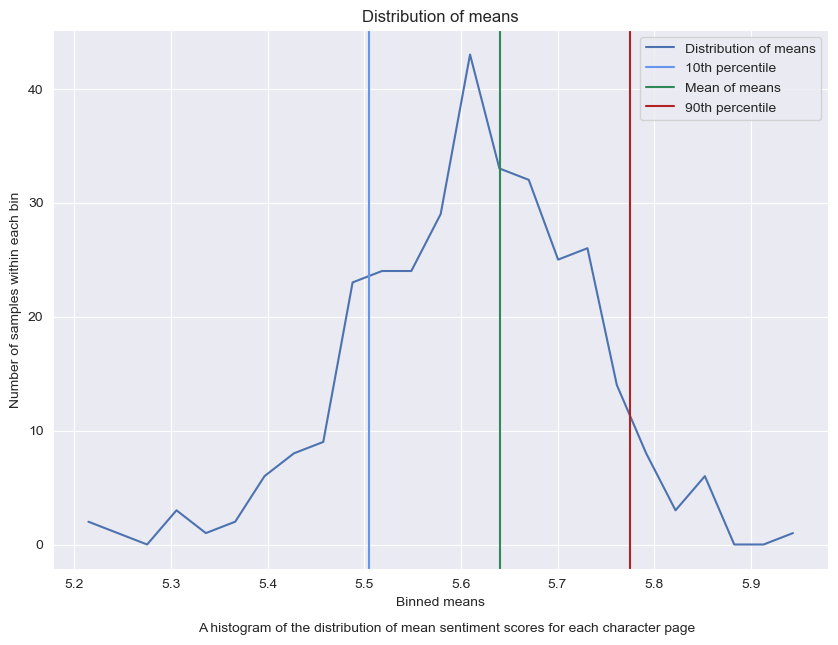

In [67]:
plt.style.use('seaborn-deep')
values=[]
for i in range(len(histogram[1])-1):
    values+=[histogram[1][i]-((histogram[1][i+1]-histogram[1][i])/2) ]
fig, ax= fig, ax = plt.subplots(figsize = (10,7))
ax.plot(values,histogram[0], label = "Distribution of means")
ax.axvline(x = tenth, color ="cornflowerblue", label = "10th percentile")
ax.axvline(x = overal_mean, color ="seagreen", label = "Mean of means")
ax.axvline(x = ninetieth, color ="firebrick", label = "90th percentile")
ax.legend()
ax.set_title('Distribution of means')
ax.set_xlabel("Binned means")
ax.set_ylabel("Number of samples within each bin")
plt.figtext(0.27,0.02, 'A histogram of the distribution of mean sentiment scores for each character page')
plt.show()

### Task: grab the good/bad character names

Reading data on moral orientation of characters


In [47]:
morals = pd.read_csv("../provided_csvs/wiki_meta_data.csv", skiprows=0, index_col=0)
morals.head()

,CharacterName,WikiLink,universe,woman,man,good,bad
0,Abomination,Abomination (character),Marvel,0,1,0,1
1,Absorbing Man,Absorbing Man,Marvel,0,1,0,1
2,Achebe,Achebe (comics),Marvel,0,0,0,0
3,Agent,Agent (comics),Marvel,0,1,1,0
4,Agent X,Agent X (Marvel Comics),Marvel,0,1,1,0


Since there are some characters that have wiki pages for their membership of both universes, we need to enumerate over wikilinks and not character names. However, some characters have multiple wikilinks.
We therefore split the wikilinks and only use the first, which matches how the text was acquired.

In [48]:
morals["split_wikilinks"] = [x.split("|") for x in list(morals['WikiLink'].values)]
df_superhero["new_link_format"] = [link[2:-2] for link in df_superhero["WikiLink"]] #matching exact format of the above

### Task: calculate the same stats for only good/bad characters

In [59]:
bad_sent = []
neutral_sent = []
good_sent = []
already_assigned = []
for index, link in enumerate(morals["split_wikilinks"].values):
    if link[0] in df_superhero["new_link_format"].values: #taking only the first link if multiple
        if morals["good"][index] == 1:
            good_sent.append(df_superhero["Sentiment"][df_superhero["new_link_format"] == link[0]].values)
        elif morals["bad"][index] == 1:
            bad_sent.append(df_superhero["Sentiment"][df_superhero["new_link_format"] == link[0]].values)
        elif (morals["good"][index] and morals["bad"][index]) == 0:
            neutral_sent.append(df_superhero["Sentiment"][df_superhero["new_link_format"] == link[0]].values)
        else:
            print(f"{link} with index {index} could not be classified")

bad_sent = [float(i) for i in bad_sent]
neutral_sent = [i for i in neutral_sent if i != None]
neutral_sent = [float(i) for i in neutral_sent] #these will not be used as specified in the project description
good_sent = [float(i) for i in good_sent]


print(f"There are {len(bad_sent)} bad characters with a mean sentiment score of {np.mean(bad_sent):.2f}")
print(f"There are {len(neutral_sent)} neutral characters with a mean sentiment score of {np.mean(neutral_sent):.2f}")
print(f"There are {len(good_sent)} good characters with a mean sentiment score of {np.mean(good_sent):.2f}")

There are 345 bad characters with a mean sentiment score of 5.56
There are 908 neutral characters with a mean sentiment score of 5.61
There are 323 good characters with a mean sentiment score of 5.64


### Task: plot the histograms for the good/bad group and indicate the values of the mean, etc.

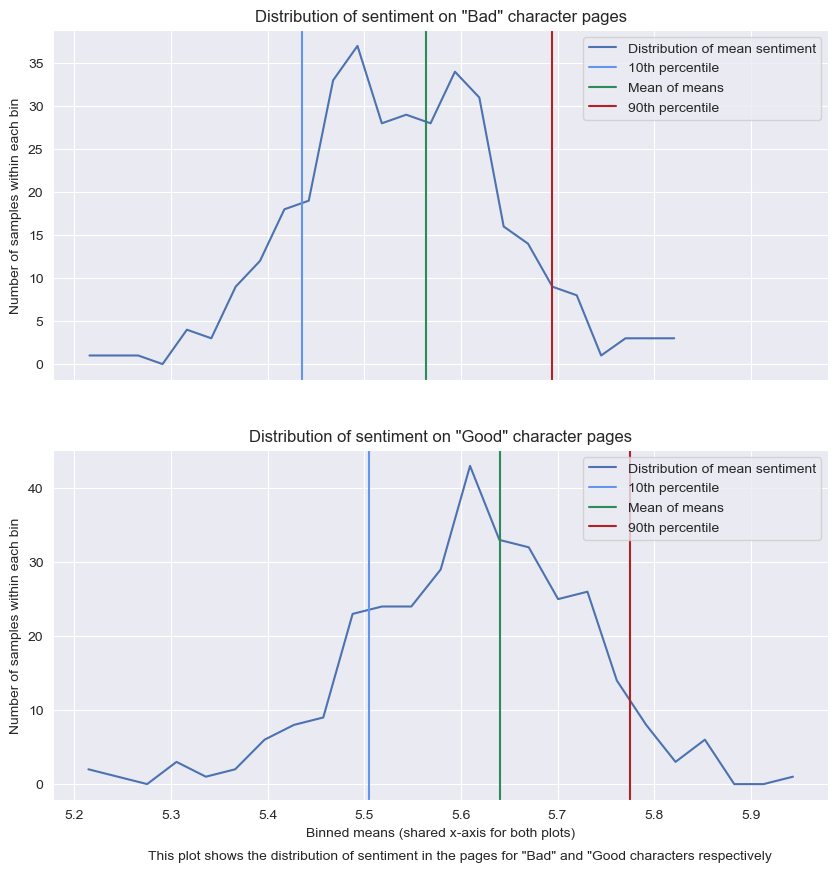

In [68]:
plt.style.use('seaborn-deep')

fig, ax= fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True) #deliberately not using sharey=True, since we are interested in proportion and not absolute numbers

means, overal_mean, ninetieth, tenth, histogram = get_histogram_data(bad_sent)
values=[]
for i in range(len(histogram[1])-1):
    values+=[histogram[1][i]-((histogram[1][i+1]-histogram[1][i])/2) ]
ax[0].plot(values,histogram[0], label = "Distribution of mean sentiment")
ax[0].axvline(x = tenth, color ="cornflowerblue", label = "10th percentile")
ax[0].axvline(x = overal_mean, color ="seagreen", label = "Mean of means")
ax[0].axvline(x = ninetieth, color ="firebrick", label = "90th percentile")
ax[0].legend(loc = 'upper right')
ax[0].set_title('Distribution of sentiment on "Bad" character pages')
ax[0].set_ylabel("Number of samples within each bin")

means, overal_mean, ninetieth, tenth, histogram = get_histogram_data(good_sent)
values=[]
for i in range(len(histogram[1])-1):
    values+=[histogram[1][i]-((histogram[1][i+1]-histogram[1][i])/2) ]
ax[1].plot(values,histogram[0], label = "Distribution of mean sentiment")
ax[1].axvline(x = tenth, color ="cornflowerblue", label = "10th percentile")
ax[1].axvline(x = overal_mean, color ="seagreen", label = "Mean of means")
ax[1].axvline(x = ninetieth, color ="firebrick", label = "90th percentile")
ax[1].legend(loc = 'upper right')
ax[1].set_title('Distribution of sentiment on "Good" character pages')
ax[1].set_xlabel("Binned means (shared x-axis for both plots)")
ax[1].set_ylabel("Number of samples within each bin")

plt.figtext(0.22, 0.05, 'This plot shows the distribution of sentiment in the pages for "Bad" and "Good characters respectively')

plt.show()

### Task: use the label permutation test (see Week 5) to investigate the two hypotheses below
* H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.
* H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.

First we store all the sentiment values for the character pages which were not empty.
This includes good, bad and "neutral" characters - i.e. those who were assigned neither the good nor bad label

In [64]:
sent_scores = [value for value in df_superhero["Sentiment"].values if value != None]


First we write the code for performing a permutation test. This follows the method described on wikipedia

In [81]:
def permutation_test(sent_scores,HX):
    """
    :param sent_scores - contains sentiment scores for all charcter pages :
    :param HX: - contains sentment scores for the subset of interest: either "Good" or "Bad" character pages
    :return: original diff - a float value for the difference between means of the good/bad subset and a random subset of equal length
    :return: diff_in_mean_list - a list of differences in means between random permutations of the above two mentioned subsets
    :return: p_value - a float value for the two-sided p-value of the permutation test
    """
    n = len(HX)
    #first we take a sample from all sentiment scores of similar size to the good/bad character sentiment scores in question
    subset = random.sample(sent_scores,n)

    #next we calculate the means
    HX_mean = np.mean(HX)
    random_mean = np.mean(subset)
    original_diff = HX_mean - random_mean

    #now the two are pooled
    pooled = subset + HX

    diff_in_mean_list = []
    for i in range(10000):
        permutation = np.random.permutation(pooled) #we permute them and divide them up into subsets of equal length
        A = permutation[n:]
        B = permutation[:n]
        diff = np.mean(A)-np.mean(B)
        diff_in_mean_list.append(diff)

     #Calculating the two-sided p-value for whether the hypothesis should be rejected
    p_value = 0
    for sample in diff_in_mean_list:
        if abs(sample) > abs(original_diff):
            p_value =+1
    if p_value > 0: #to avoid dividing by zero error
        p_value = p_value / len(diff_in_mean_list)

    return original_diff, diff_in_mean_list, p_value

Using permutation test, e now test the H1 hypotheses: that good characters have a higher mean sentiment score than a random subset of characters of similar size
The H0 hypothesis is that there is no difference in means between good characters and the random subset

In [102]:
original_diff, diff_in_mean_list, p_value = permutation_test(sent_scores,good_sent)
print(f"The p-value was {p_value}, which means that we can reject the H0 hypothesis. "
      f"Since the difference in means was {original_diff:.2f}, we find that good characters have significantly higher mean sentiment score than a random subset of characters")


The p-value was 0.0001, which means that we can reject the H0 hypothesis. Since the difference in means was 0.03, we find that good characters have significantly higher mean sentiment score than a random subset of characters


Similarly for the H2 hypothesis regarding bad characters having a lower mean sentiment score.
The H0 hypothesis is again that there is no difference

In [99]:
original_diff, diff_in_mean_list, p_value = permutation_test(sent_scores,bad_sent)
print(f"The p-value was {p_value}, which means that we can reject the H0 hypothesis. "
      f"Since the difference in means was {original_diff:.2f}, we find that bad characters have significantly lower mean sentiment score than a random subset of characters")

The p-value was 0.0001, which means that we can reject the H0 hypothesis. Since the difference in means was -0.03, we find that bad characters have significantly lower mean sentiment score than a random subset of characters


### Task: write a short paragraph reflecting on your findings.

# MISSING

# Appendix
### Visualiztions of results using permutation tests

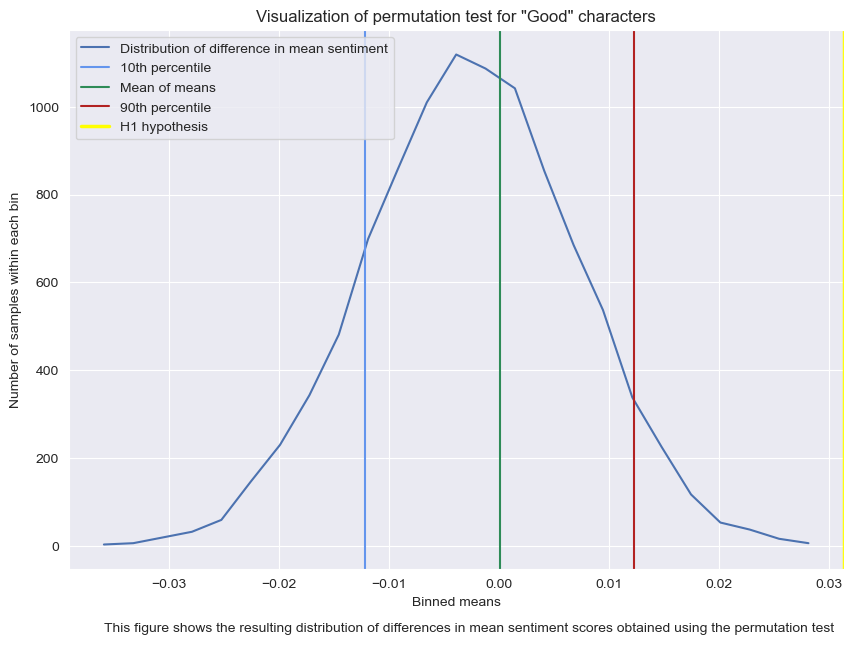

In [103]:
means, overal_mean, ninetieth, tenth, histogram = get_histogram_data(diff_in_mean_list)
plt.style.use('seaborn-deep')
values=[]
for i in range(len(histogram[1])-1):
    values+=[histogram[1][i]-((histogram[1][i+1]-histogram[1][i])/2) ]
fig, ax= fig, ax = plt.subplots(figsize = (10,7))
ax.plot(values,histogram[0], label = "Distribution of difference in mean sentiment")
ax.axvline(x = tenth, color ="cornflowerblue", label = "10th percentile")
ax.axvline(x = overal_mean, color ="seagreen", label = "Mean of means")
ax.axvline(x = ninetieth, color ="firebrick", label = "90th percentile")
ax.axvline(x = original_diff, color = "yellow", label = "H1 hypothesis", linewidth= 2.5)

ax.legend()

ax.set_title('Visualization of permutation test for "Good" characters')
ax.set_xlabel("Binned means")
ax.set_ylabel("Number of samples within each bin")
plt.figtext(0.16, 0.02, "This figure shows the resulting distribution of differences in mean sentiment scores obtained using the permutation test")
plt.show()

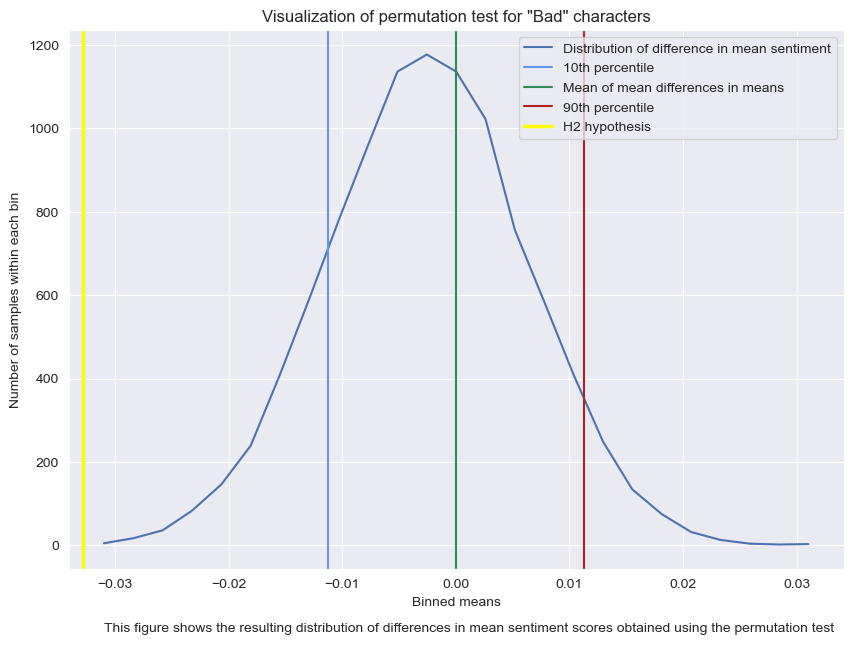

In [101]:
means, overal_mean, ninetieth, tenth, histogram = get_histogram_data(diff_in_mean_list)
plt.style.use('seaborn-deep')
values=[]
for i in range(len(histogram[1])-1):
    values+=[histogram[1][i]-((histogram[1][i+1]-histogram[1][i])/2) ]
fig, ax= fig, ax = plt.subplots(figsize = (10,7))
ax.plot(values,histogram[0], label = "Distribution of difference in mean sentiment")
ax.axvline(x = tenth, color ="cornflowerblue", label = "10th percentile")
ax.axvline(x = overal_mean, color ="seagreen", label = "Mean of mean differences in means")
ax.axvline(x = ninetieth, color ="firebrick", label = "90th percentile")
ax.axvline(x = original_diff, color = "yellow", label = "H2 hypothesis", linewidth= 2.5)

ax.legend()

ax.set_title('Visualization of permutation test for "Bad" characters')
ax.set_xlabel("Binned means")
ax.set_ylabel("Number of samples within each bin")
plt.figtext(0.16, 0.02, "This figure shows the resulting distribution of differences in mean sentiment scores obtained using the permutation test")
plt.show()